# 01 — Explore Boundary Data

Use this notebook to load and inspect the enumeration area boundaries and control grid files from Google Drive.

**What this notebook covers:**
- Loading project configuration
- Reading boundary GeoJSON files from Google Drive
- Inspecting schema, CRS, and geometry types
- Quick visualization of boundaries

## Setup

Add the project root to the Python path so we can import our `src` modules.

In [1]:
# Standard library
import sys
from pathlib import Path

# Third-party
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Local imports (after path setup)
from src.utils.config_loader import load_config, get_data_dir, get_output_dir
from src.data_processing.load_boundaries import build_control_grid, save_control_grid

# Configuration
config = load_config()
DATA_DIR = get_data_dir(config)
OUTPUT_DIR = get_output_dir(config)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data exists:  {DATA_DIR.exists()}")
print(f"Data dir:     {DATA_DIR}")
print(f"Output dir:   {OUTPUT_DIR}")

Loaded local config overrides from config.local.yaml
Project root: c:\projects
Data exists:  True
Data dir:     G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial
Output dir:   G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial\02_outputs



The config loader reads `config/config.yaml` and merges any local overrides from `config/config.local.yaml`. This way your local Google Drive path stays out of version control.

## Explore Study Area File

Load the Study_Area_30km.geojson and inspect what's inside — columns, CRS, geometry types, and a quick plot.

In [2]:
# Load the study area file
grid_5km_path = DATA_DIR / "01_input_data" / "boundaries" / "Area_study_5km_grid.gpkg"
grid_5km = gpd.read_file(grid_5km_path)

print(f"Shape:          {grid_5km.shape}")
print(f"CRS:            {grid_5km.crs}")
print(f"Geometry types: {grid_5km.geom_type.unique()}")
print(f"\nColumns: {list(grid_5km.columns)}")
print(f"\nDtypes:\n{grid_5km.dtypes}")
grid_5km.head(10)


Shape:          (905, 9)
CRS:            EPSG:32736
Geometry types: <StringArray>
['MultiPolygon']
Length: 1, dtype: str

Columns: ['id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index', 'id5km', 'geometry']

Dtypes:
id              int64
left          float64
top           float64
right         float64
bottom        float64
row_index       int64
col_index       int64
id5km           int32
geometry     geometry
dtype: object


,id,left,top,right,bottom,row_index,col_index,id5km,geometry
0,9821,818536.9001,9.277550e+06,823536.9001,9.272550e+06,68,53,9821,"MULTIPOLYGON (((822369.204 9274626.685, 823536..."
1,9822,818536.9001,9.272550e+06,823536.9001,9.267550e+06,69,53,9822,"MULTIPOLYGON (((821616.326 9272549.999, 823536..."
2,9823,818536.9001,9.267550e+06,823536.9001,9.262550e+06,70,53,9823,"MULTIPOLYGON (((819279.233 9266103.529, 819803..."
3,9824,818536.9001,9.262550e+06,823536.9001,9.257550e+06,71,53,9824,"MULTIPOLYGON (((819121.211 9262549.999, 823536..."
4,9825,818536.9001,9.257550e+06,823536.9001,9.252550e+06,72,53,9825,"MULTIPOLYGON (((818876.477 9257046.494, 818898..."
5,9826,818536.9001,9.252550e+06,823536.9001,9.247550e+06,73,53,9826,"MULTIPOLYGON (((821197.719 9248282.708, 820067..."
6,9827,818536.9001,9.247550e+06,823536.9001,9.242550e+06,74,53,9827,"MULTIPOLYGON (((821659.425 9247549.999, 823536..."
7,10004,823536.9001,9.282550e+06,828536.9001,9.277550e+06,67,54,10004,"MULTIPOLYGON (((827864.201 9281837.587, 828167..."
8,10005,823536.9001,9.277550e+06,828536.9001,9.272550e+06,68,54,10005,"MULTIPOLYGON (((824596.887 9277549.999, 828536..."
9,10006,823536.9001,9.272550e+06,828536.9001,9.267550e+06,69,54,10006,"MULTIPOLYGON (((823536.9 9272549.999, 828536.9..."


In [3]:
#merge with control areas sampled
control_sampled_path = DATA_DIR / "01_input_data" / "boundaries" / "Rubeho_control_areas_sampled.csv"
control_sampled = pd.read_csv(control_sampled_path)
print(control_sampled.shape)

control_sampled.head()
control_sampled.control_pixel_sampled.value_counts(dropna=False
                                                       )

print("grid_5km columns:", list(grid_5km.columns))
print("sampled columns:", list(control_sampled.columns))

#merge sampled areas with flags
# Only keep control areas (sampled=1 or replacement=0)
control_ids = control_sampled[control_sampled["control_pixel_sampled"].isin([0, 1])]
id_to_status = control_ids.set_index("grid_id")["control_pixel_sampled"].map({1: "sampled", 0: "replacement"})

grid_5km["sample_status"] = grid_5km["id"].map(id_to_status)

print(grid_5km["sample_status"].value_counts(dropna=False))
grid_5km.head(10)

# Verify counts match source data
assert (grid_5km["sample_status"] == "sampled").sum() == (control_sampled["control_pixel_sampled"] == 1).sum(), "Sampled count mismatch"
assert (grid_5km["sample_status"] == "replacement").sum() == (control_sampled["control_pixel_sampled"] == 0).sum(), "Replacement count mismatch"

print("Counts match")
print(grid_5km["sample_status"].value_counts(dropna=False))



grid_5km

(48, 96)
grid_5km columns: ['id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index', 'id5km', 'geometry']
sampled columns: ['grid_id', 'matched_treatment', 'treated_id', 'matched_control', 'control_id', 'p_treated', 'p_control', 'abs_diff', 'excluded', 'water_perc', 'trees_perc', 'flooded_vegetation_perc', 'crops_perc', 'built_area_perc', 'bare_ground_perc', 'rangeland_perc', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'a36', 'a37', 'a38', 'a39', 'a40', 'a41', 'a42', 'a43', 'a44', 'a45', 'a46', 'a47', 'a48', 'a49', 'a50', 'a51', 'a52', 'a53', 'a54', 'a55', 'a56', 'a57', 'a58', 'a59', 'a60', 'a61', 'a62', 'a63', 'c_nightlights_2025', 'c_nightlights_2023', 'c_dist_builtup_2025', 'c_dist_highway_2025', 'c_dist_waterway_2025', 'c_dist_intersection_2025', 'c_elevation', 'c_slop

,id,left,top,right,bottom,row_index,col_index,id5km,geometry,sample_status
0,9821,818536.9001,9.277550e+06,823536.9001,9.272550e+06,68,53,9821,"MULTIPOLYGON (((822369.204 9274626.685, 823536...",NaN
1,9822,818536.9001,9.272550e+06,823536.9001,9.267550e+06,69,53,9822,"MULTIPOLYGON (((821616.326 9272549.999, 823536...",NaN
2,9823,818536.9001,9.267550e+06,823536.9001,9.262550e+06,70,53,9823,"MULTIPOLYGON (((819279.233 9266103.529, 819803...",NaN
3,9824,818536.9001,9.262550e+06,823536.9001,9.257550e+06,71,53,9824,"MULTIPOLYGON (((819121.211 9262549.999, 823536...",NaN
4,9825,818536.9001,9.257550e+06,823536.9001,9.252550e+06,72,53,9825,"MULTIPOLYGON (((818876.477 9257046.494, 818898...",NaN
...,...,...,...,...,...,...,...,...,...,...
900,15729,978536.9001,9.177550e+06,983536.9001,9.172550e+06,88,85,15729,"MULTIPOLYGON (((979923.734 9172549.999, 978536...",NaN
901,15730,978536.9001,9.172550e+06,983536.9001,9.167550e+06,89,85,15730,"MULTIPOLYGON (((981031.453 9168753.776, 980965...",NaN
902,15731,978536.9001,9.167550e+06,983536.9001,9.162550e+06,90,85,15731,"MULTIPOLYGON (((980689.845 9162549.999, 978536...",NaN
903,15732,978536.9001,9.162550e+06,983536.9001,9.157550e+06,91,85,15732,"MULTIPOLYGON (((980475.095 9158650.039, 980017...",NaN


In [4]:
print(grid_5km['id'].value_counts(dropna=False))


id
9821     1
9822     1
9823     1
9824     1
9825     1
        ..
15729    1
15730    1
15731    1
15732    1
15733    1
Name: count, Length: 905, dtype: int64


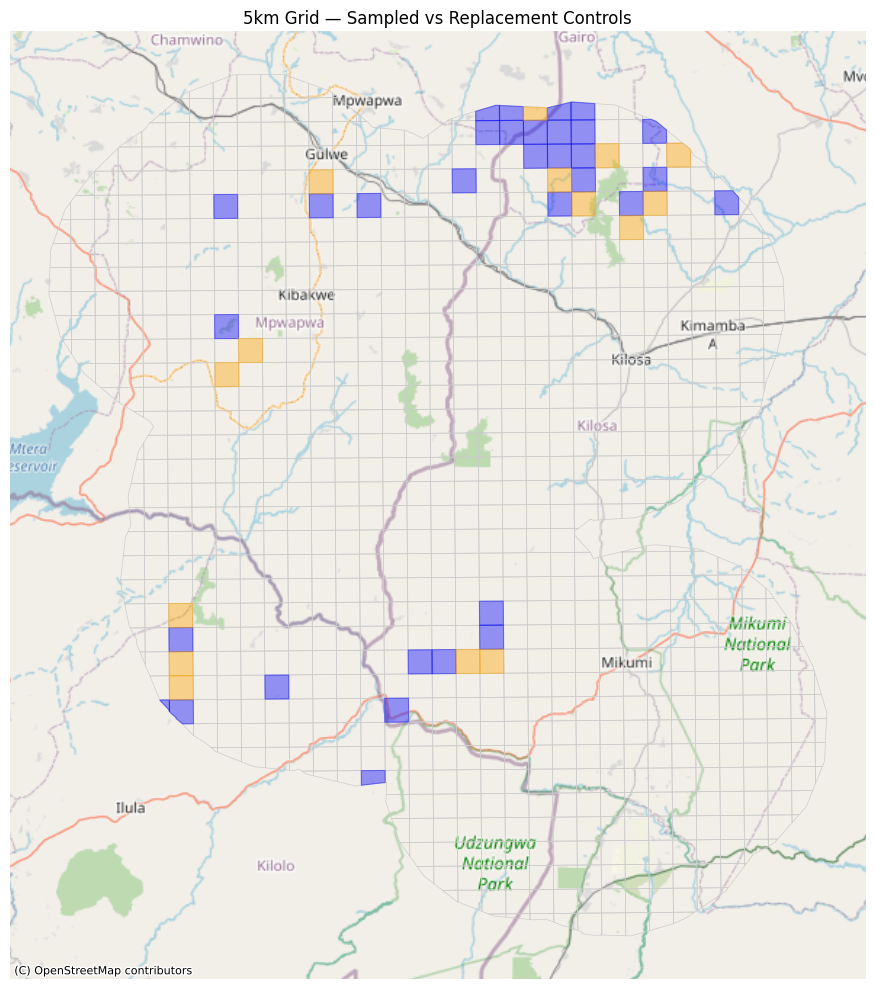

In [5]:
grid_5km_wm = grid_5km.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# All grid cells as background
grid_5km_wm.plot(ax=ax, facecolor="none", edgecolor="#CCCCCC", linewidth=0.5)

# Sampled controls
grid_5km_wm[grid_5km_wm["sample_status"] == "sampled"].plot(
    ax=ax, facecolor="blue", edgecolor="blue", linewidth=0.8, alpha=0.4, label="Sampled"
)

# Replacements
grid_5km_wm[grid_5km_wm["sample_status"] == "replacement"].plot(
    ax=ax, facecolor="orange", edgecolor="orange", linewidth=0.8, alpha=0.4, label="Replacement"
)

import contextily as cx
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("5km Grid — Sampled vs Replacement Controls")
ax.set_axis_off()
plt.tight_layout()
plt.show()


## Load control grid cells
The control grid areas file should be at:
```
<data_dir>/01_input_data/boundaries/control_grid_5km_flagged.gpkg
```

In [6]:

control_grid = build_control_grid(DATA_DIR)
save_control_grid(control_grid, DATA_DIR)
control_grid.head()





Loaded 905 grid cells from G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial\01_input_data\boundaries\Area_study_5km_grid.gpkg
Loaded 48 control sample records from G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial\01_input_data\boundaries\Rubeho_control_areas_sampled.csv
Saved full study grid (905 cells) to G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial\01_input_data\boundaries\study_area_5km_flagged.gpkg
Built control grid: 48 cells (33 sampled, 15 replacement)
Saved control grid (48 cells) to G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial\01_input_data\boundaries\control_grid_5km_flagged.gpkg


,id,left,top,right,bottom,row_index,col_index,id5km,geometry,sample_status
77,10578,838536.9001,9.172550e+06,843536.9001,9.167550e+06,89,57,10578,"MULTIPOLYGON (((843442.487 9170271.988, 843536...",sampled
100,10758,843536.9001,9.192550e+06,848536.9001,9.187550e+06,85,58,10758,"MULTIPOLYGON (((843536.9 9192549.999, 848536.9...",replacement
101,10759,843536.9001,9.187550e+06,848536.9001,9.182550e+06,86,58,10759,"MULTIPOLYGON (((843536.9 9187549.999, 848536.9...",sampled
102,10760,843536.9001,9.182550e+06,848536.9001,9.177550e+06,87,58,10760,"MULTIPOLYGON (((843536.9 9182549.999, 848536.9...",replacement
103,10761,843536.9001,9.177550e+06,848536.9001,9.172550e+06,88,58,10761,"MULTIPOLYGON (((843536.9 9177549.999, 848536.9...",replacement


## Load full grid if neccesary

The control grid is the set of cells that each enumerator will use for navigation.

In [7]:
full_grid = gpd.read_file(DATA_DIR / "01_input_data" / "boundaries" / "study_area_5km_flagged.gpkg")
full_grid.head()

,id,left,top,right,bottom,row_index,col_index,id5km,sample_status,geometry
0,9821,818536.9001,9.277550e+06,823536.9001,9.272550e+06,68,53,9821,NaN,"MULTIPOLYGON (((822369.204 9274626.685, 823536..."
1,9822,818536.9001,9.272550e+06,823536.9001,9.267550e+06,69,53,9822,NaN,"MULTIPOLYGON (((821616.326 9272549.999, 823536..."
2,9823,818536.9001,9.267550e+06,823536.9001,9.262550e+06,70,53,9823,NaN,"MULTIPOLYGON (((819279.233 9266103.529, 819803..."
3,9824,818536.9001,9.262550e+06,823536.9001,9.257550e+06,71,53,9824,NaN,"MULTIPOLYGON (((819121.211 9262549.999, 823536..."
4,9825,818536.9001,9.257550e+06,823536.9001,9.252550e+06,72,53,9825,NaN,"MULTIPOLYGON (((818876.477 9257046.494, 818898..."


# Quick script to generate smaller grid cells (500m by 500m) based on existing auxiliary data. 
Plot enumeration areas and control grid cells together to verify the data looks correct.

In [8]:
# src = r"G:\Shared drives\TZ-CCT_RUBEV-0825\Data\Data\0.1_geospatial data\aux_shapefile\grid_500m_5km_ID.shp"

# # Build a WHERE clause for  the 48 control IDs AND the treatment IDs, 
# control_ids = control_grid["id"].astype(int).tolist()
# id_list = ",".join(str(i) for i in control_ids)
# where_clause = f'"5km_id" IN ({id_list}) OR "is_treatme" = \'True\''

# subgrid = gpd.read_file(src, engine="pyogrio", where=where_clause)

# print(f"Shape: {subgrid.shape}")
# print(f"Unique 5km IDs: {subgrid['5km_id'].nunique()}")
# print(f"is_treatme values: {subgrid['is_treatme'].unique()}")
# subgrid.head(10)


In [9]:
# output_path = DATA_DIR / "01_input_data/boundaries/subgrid_500m_control_treatment.gpkg"
# subgrid.to_file(output_path, driver="GPKG")
# print(f"Saved {len(subgrid)} rows to {output_path}")



# Load the saved 500m subgrid


In [10]:
subgrid = gpd.read_file(DATA_DIR / "01_input_data/boundaries/subgrid_500m_control_treatment.gpkg")
subgrid_treatment = subgrid[subgrid["is_treatme"] == "True"]
control_ids = set(control_grid["id"].astype(int))

subgrid_control = subgrid[subgrid["5km_id"].isin(control_ids)]

#note geometry are points, not polygons. 

#generating grid cells instead of points. 

In [11]:
subgrid_control.head()
subgrid_control.crs
subgrid_control.cell_size.unique()

array([500])

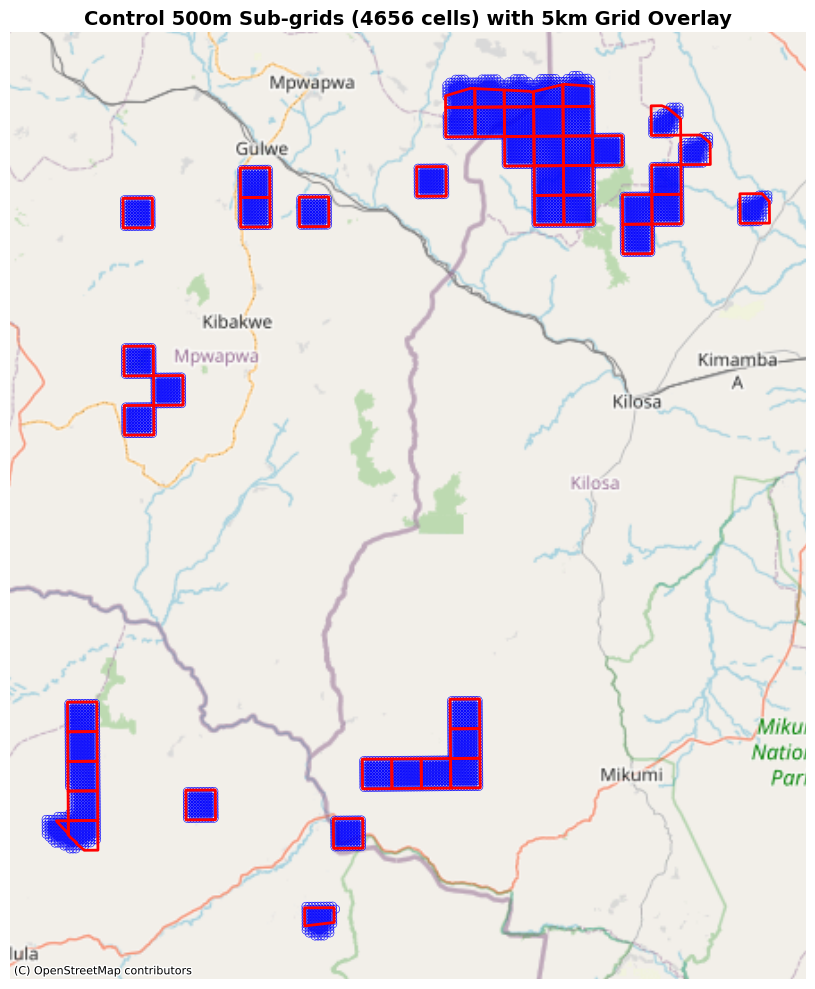

In [12]:
fig, ax = plt.subplots(figsize=(14, 10))

# 500m control sub-grid
subgrid_control.to_crs(epsg=3857).plot(
    ax=ax, facecolor="none", edgecolor="blue", linewidth=0.4
)

# 5km control grid overlay
control_grid.to_crs(epsg=3857).plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=2
)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.set_title(f"Control 500m Sub-grids ({len(subgrid_control)} cells) with 5km Grid Overlay", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


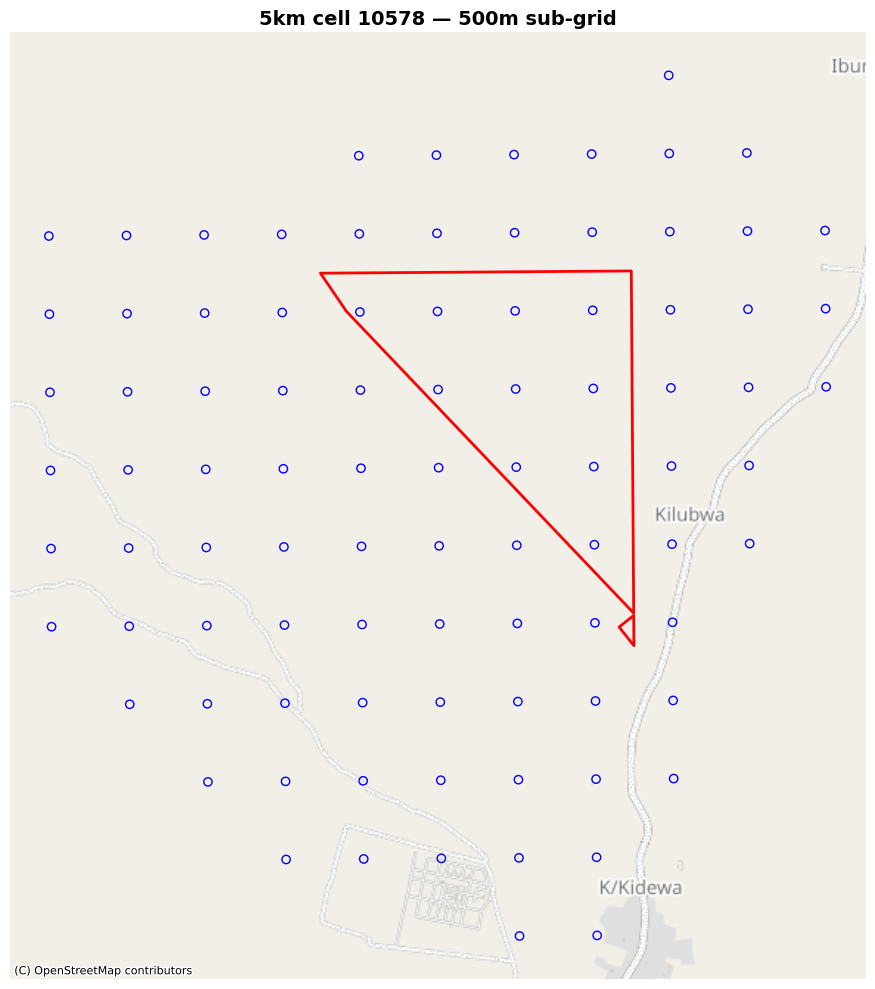

In [17]:
test_5km_id = control_grid["id"].iloc[0]
cell_5km = control_grid[control_grid["id"] == test_5km_id]
cells_500m = subgrid_control[subgrid_control["5km_id"] == int(test_5km_id)]

fig, ax = plt.subplots(figsize=(10, 10))

cells_500m.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1)
cell_5km.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=14)

ax.set_axis_off()
ax.set_title(f"5km cell {test_5km_id} — 500m sub-grid", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()



C:\Users\linss\AppData\Local\Temp\ipykernel_19956\1553117766.py:7: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  cells_500m_merc.boundary.plot(ax=ax, color="blue", linewidth=0.8)


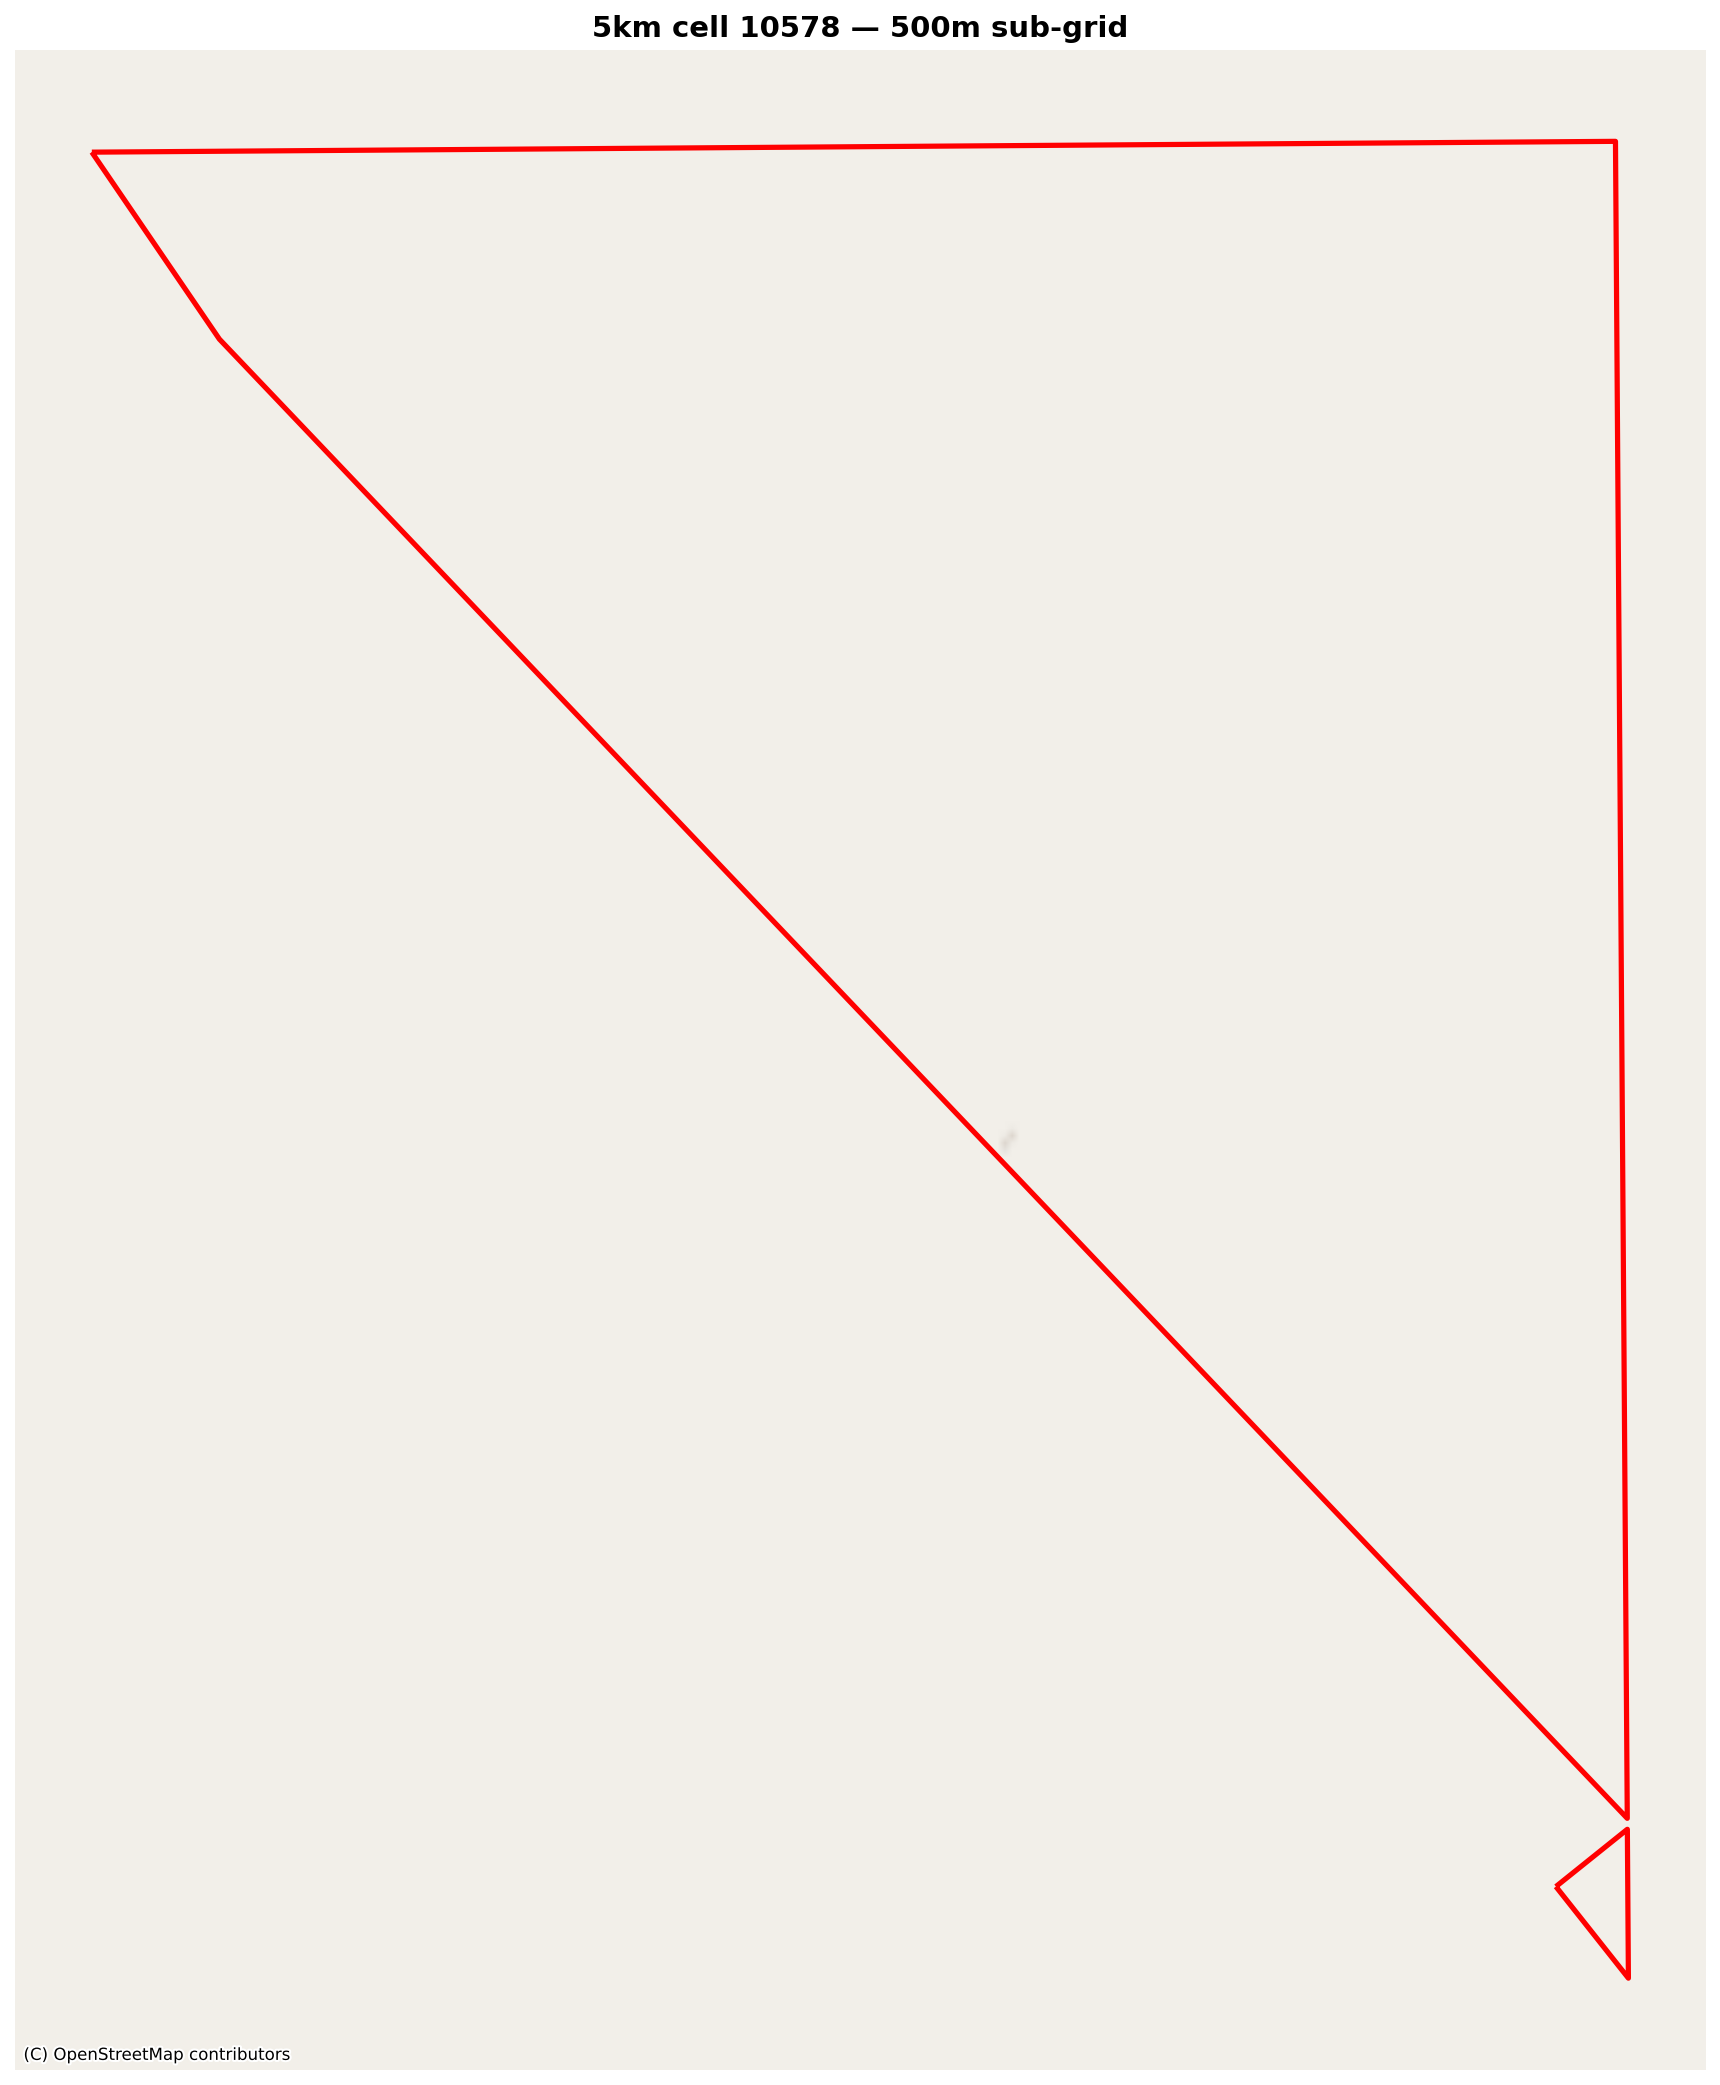

In [15]:
fig, ax = plt.subplots(figsize=(14, 14), dpi=150)

cells_500m_merc = cells_500m.to_crs(epsg=3857)
cell_5km_merc = cell_5km.to_crs(epsg=3857)

# Plot boundary explicitly
cells_500m_merc.boundary.plot(ax=ax, color="blue", linewidth=0.8)
cell_5km_merc.boundary.plot(ax=ax, color="red", linewidth=2.5)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=14)

ax.set_axis_off()
ax.set_title(f"5km cell {test_5km_id} — 500m sub-grid", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


# adjusting cell size 
From 500meters to 1km cell sizes. 

Generated 4379 sub-cells at 500m resolution
Generated 1115 sub-cells at 1000m resolution


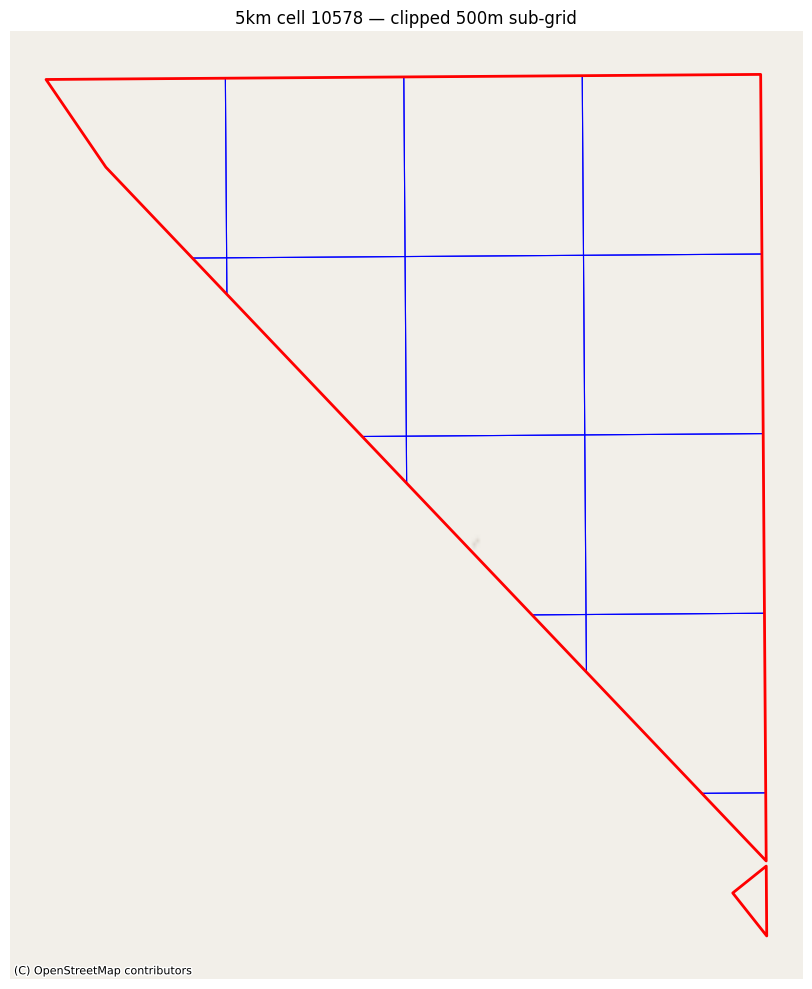

In [19]:
from shapely.geometry import box as shapely_box

def point_to_square(point, size=500):
    """Convert a point to a square polygon centered on it."""
    half = size / 2
    return shapely_box(point.x - half, point.y - half, point.x + half, point.y + half)

def generate_subgrid(subgrid_points, control_grid, cell_size=500):
    """
    Generate square sub-cells from point centroids, clipped to parent 5km cells.
    
    Args:
        subgrid_points: GeoDataFrame of 500m point centroids (must have '5km_id' column)
        control_grid: GeoDataFrame of 5km cells (must have 'id' column)
        cell_size: Size of output squares in metres (500 or 1000)
    
    Returns:
        GeoDataFrame of clipped square polygons
    """
    # For 1km cells, subsample to every other row/col
    if cell_size == 1000:
        points = subgrid_points[
            (subgrid_points["row"] % 2 == 0) & (subgrid_points["col"] % 2 == 0)
        ].copy()
    else:
        points = subgrid_points.copy()
    
    # Generate squares from points
    points["geometry"] = points.geometry.apply(point_to_square, size=cell_size)
    
    # Clip each sub-cell to its parent 5km cell
    # Build a lookup of 5km geometries
    parent_geoms = control_grid.set_index("id")["geometry"].to_dict()
    
    clipped_rows = []
    for _, row in points.iterrows():
        parent_id = int(row["5km_id"])
        if parent_id in parent_geoms:
            clipped_geom = row.geometry.intersection(parent_geoms[parent_id])
            if not clipped_geom.is_empty:
                new_row = row.copy()
                new_row["geometry"] = clipped_geom
                clipped_rows.append(new_row)
    
    result = gpd.GeoDataFrame(clipped_rows, crs=points.crs)
    print(f"Generated {len(result)} sub-cells at {cell_size}m resolution")
    return result

# Make sure control_grid is in same CRS as subgrid_control (EPSG:32736)
control_grid_utm = control_grid.to_crs(epsg=32736)

# Generate both resolutions
subgrid_500m = generate_subgrid(subgrid_control, control_grid_utm, cell_size=500)
subgrid_1km = generate_subgrid(subgrid_control, control_grid_utm, cell_size=1000)
#Then visualize to verify the clipping worked:


# Test on the non-square cell
test_5km_id = 10578
cell_5km = control_grid_utm[control_grid_utm["id"] == test_5km_id]
cells_500m = subgrid_500m[subgrid_500m["5km_id"] == test_5km_id]

fig, ax = plt.subplots(figsize=(10, 10))

cells_500m.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=0.8)
cell_5km.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=14)
ax.set_axis_off()
ax.set_title(f"5km cell {test_5km_id} — clipped 500m sub-grid")
plt.tight_layout()
plt.show()


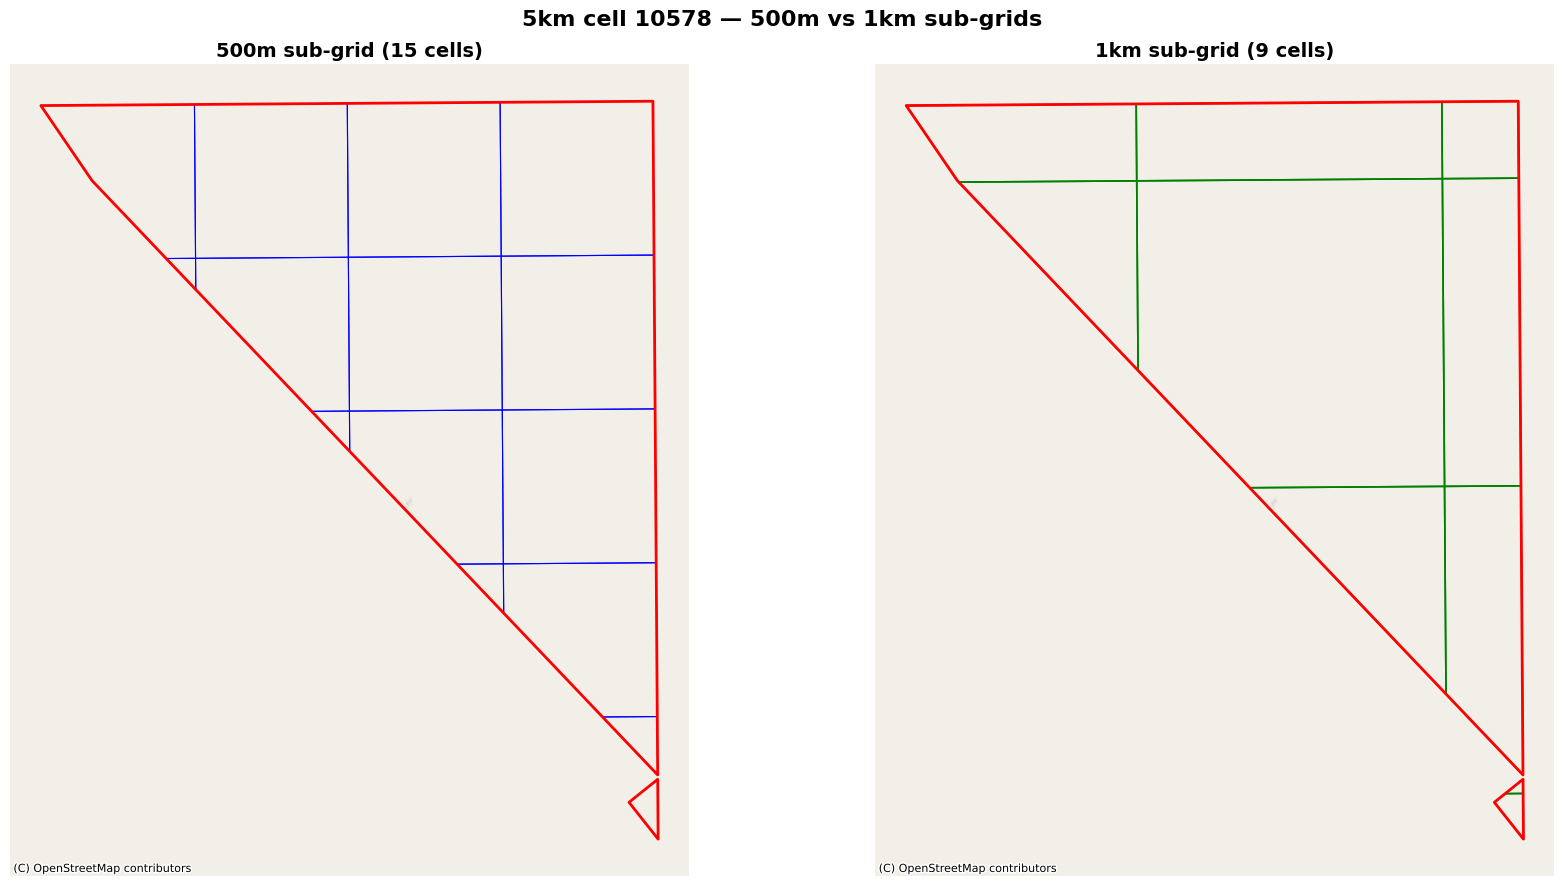

In [20]:
# Test on the non-square cell - compare 500m vs 1km
test_5km_id = 10578
cell_5km = control_grid_utm[control_grid_utm["id"] == test_5km_id]
cells_500m = subgrid_500m[subgrid_500m["5km_id"] == test_5km_id]
cells_1km = subgrid_1km[subgrid_1km["5km_id"] == test_5km_id]

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# 500m grid
cells_500m.to_crs(epsg=3857).plot(ax=axes[0], facecolor="none", edgecolor="blue", linewidth=0.8)
cell_5km.to_crs(epsg=3857).plot(ax=axes[0], facecolor="none", edgecolor="red", linewidth=2)
cx.add_basemap(axes[0], source=cx.providers.OpenStreetMap.Mapnik, zoom=14)
axes[0].set_axis_off()
axes[0].set_title(f"500m sub-grid ({len(cells_500m)} cells)", fontsize=14, fontweight="bold")

# 1km grid
cells_1km.to_crs(epsg=3857).plot(ax=axes[1], facecolor="none", edgecolor="green", linewidth=1.2)
cell_5km.to_crs(epsg=3857).plot(ax=axes[1], facecolor="none", edgecolor="red", linewidth=2)
cx.add_basemap(axes[1], source=cx.providers.OpenStreetMap.Mapnik, zoom=14)
axes[1].set_axis_off()
axes[1].set_title(f"1km sub-grid ({len(cells_1km)} cells)", fontsize=14, fontweight="bold")

plt.suptitle(f"5km cell {test_5km_id} — 500m vs 1km sub-grids", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()
